In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, find_peaks
from pathlib import Path

PROJECT_ROOT = r"C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease"
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "PaHaW_dataset")
PAHAW_PUBLIC = os.path.join(DATA_ROOT, "PaHaW_public")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("PAHAW_PUBLIC exists?", os.path.exists(PAHAW_PUBLIC))

# extra debug
if os.path.exists(DATA_ROOT):
    print("Contents of DATA_ROOT:")
    print(os.listdir(DATA_ROOT))


PROJECT_ROOT: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease
DATA_ROOT: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset
PAHAW_PUBLIC exists? True
Contents of DATA_ROOT:
['PaHaW_files', 'PaHaW_matlab', 'PaHaW_public']


In [3]:
def load_svc(path):
    data = np.loadtxt(path, skiprows=1)

    df = pd.DataFrame({
        "y": data[:, 0],
        "x": data[:, 1],
        "time": data[:, 2] - np.min(data[:, 2]),
        "pen": data[:, 3],
        "azim": data[:, 4],
        "alt": data[:, 5],
        "press": data[:, 6],
    })
    return df

# test one file
sample_file = sorted(glob.glob(os.path.join(PAHAW_PUBLIC, "*", "*.svc")))[0]
df = load_svc(sample_file)

print("Loaded:", sample_file)
print(df.shape)
display(df.head())


Loaded: C:\Users\aibel\OneDrive\Desktop\Heizel Ann Joseph\Parkinsons Disease\data\PaHaW_dataset\PaHaW_public\00001\00001__1_1.svc
(1772, 7)


,y,x,time,pen,azim,alt,press
0,4161.0,2474.0,0.0,1.0,3447.0,633.0,78.0
1,4164.0,2472.0,7.0,1.0,3457.0,624.0,124.0
2,4166.0,2472.0,15.0,1.0,3457.0,624.0,162.0
3,4167.0,2471.0,22.0,1.0,3457.0,624.0,212.0
4,4168.0,2471.0,30.0,1.0,3457.0,624.0,266.0


In [4]:
def preprocess_df(df):
    df = df.copy()

    # smooth x,y
    if len(df) >= 7:
        df['x_s'] = savgol_filter(df['x'], 7, 2)
        df['y_s'] = savgol_filter(df['y'], 7, 2)
    else:
        df['x_s'] = df['x']
        df['y_s'] = df['y']

    t = df['time'].values.astype(float)
    vx = np.gradient(df['x_s'], t)
    vy = np.gradient(df['y_s'], t)

    df['speed'] = np.sqrt(vx**2 + vy**2)

    # curvature κ = |x'y'' − y'x''| / (x'^2 + y'^2)^(3/2)
    ax = np.gradient(vx, t)
    ay = np.gradient(vy, t)

    denom = (vx**2 + vy**2)**1.5
    denom[denom == 0] = np.nan
    df['curvature'] = np.abs(vx*ay - vy*ax) / denom

    return df

df = preprocess_df(df)
display(df[['x_s','y_s','speed','curvature']].head())


,x_s,y_s,speed,curvature
0,2473.666667,4161.357143,0.357790,0.000398
1,2472.642857,4163.642857,0.313932,0.000906
2,2471.785714,4165.571429,0.253886,0.012609
3,2471.095238,4167.142857,0.193654,0.003516
4,2470.809524,4168.190476,0.141619,0.132946


In [5]:
def segment_by_pen(df):
    strokes = []
    in_stroke = False
    start = 0

    for i, pen in enumerate(df['pen']):
        if pen == 1 and not in_stroke:
            start = i
            in_stroke = True
        elif pen == 0 and in_stroke:
            strokes.append((start, i-1))
            in_stroke = False

    if in_stroke:
        strokes.append((start, len(df)-1))

    return strokes

pen_strokes = segment_by_pen(df)
print("Pen strokes found:", len(pen_strokes))
pen_strokes[:5]


Pen strokes found: 1


[(0, 1771)]

In [6]:
def split_stroke_by_velocity(df, start, end, prom=0.05, dist=8):
    seg = df.iloc[start:end+1]

    speed = seg['speed'].values
    peaks, _ = find_peaks(speed, prominence=prom*np.nanmax(speed), distance=dist)

    if len(peaks) == 0:
        return [(start, end)]

    cuts = [start] + [start + int(p) for p in peaks] + [end]
    subs = []

    for i in range(len(cuts)-1):
        s = cuts[i]
        e = cuts[i+1]
        if e - s >= 6:
            subs.append((s, e))

    return subs


In [7]:
all_substrokes = []

for (s, e) in pen_strokes:
    subs = split_stroke_by_velocity(df, s, e)
    all_substrokes.extend(subs)

print("Total sub-strokes:", len(all_substrokes))
all_substrokes[:8]


Total sub-strokes: 63


[(0, 47),
 (47, 67),
 (67, 96),
 (96, 113),
 (113, 132),
 (132, 180),
 (180, 238),
 (238, 264)]

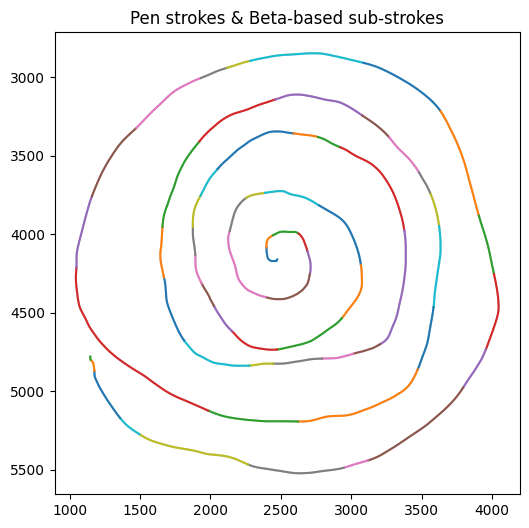

In [8]:
plt.figure(figsize=(6,6))
plt.plot(df['x_s'], df['y_s'], color='lightgray')

for (s,e) in all_substrokes:
    plt.plot(df['x_s'].iloc[s:e+1], df['y_s'].iloc[s:e+1])

plt.gca().invert_yaxis()
plt.title("Pen strokes & Beta-based sub-strokes")
plt.show()
